In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
# from sklearnex import patch_sklearn; patch_sklearn()
import scipy.io as sio
import pysindy as ps
from tqdm import trange

from pymoo_ga import *
# NSGA2, DNSGA2, SMSEMOA, AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
# from okridge.solvel0 import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator
from bayesian_model_evidence import log_evidence

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ARDRegression

mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
L0BnB is not installed.


In [2]:
n_poly = 6
n_derivatives = 6
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
print(os.listdir(data_path))
data = sio.loadmat(os.path.join(data_path, "kuramoto_sivishinky.mat"))
u_clean = (data['uu']).real; u = u_clean.copy()
x = data['x'].ravel()
t = data['tt'].ravel()
dt = t[1]-t[0]; dx = x[2]-x[1]

['KdV_sine_rep_big.mat', 'kuramoto_sivishinky.mat', 'lorenz100.npy', 'Wave_equation', 'KdV_rudy.mat', 'lorenz10.npy', 'KG_Exp.mat', 'burgers.mat']


### Add noise

In [4]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


### Gaussian process
    - removing entries in x that show high std

In [5]:
# import gpax

# bm3d_file = f"./Denoised_data/ks_{noise_type}{int(noise_lv)}_bm3d.npy"
# load_denoised_data = True
# if load_denoised_data:
#     print("Loading denoised data...")
#     u = np.load(bm3d_file)
# else:
#     print("Denoising")
#     n_sampled_t = 10
#     xx = colvec(x)
#     u_std = np.ones((u.shape[0], n_sampled_t))
#     for i in range(n_sampled_t):
#         rng_key_train, rng_key_predict = gpax.utils.get_keys()
    
#         gp_model = gpax.ExactGP(1, kernel='RBF')
#         gp_model.fit(rng_key_train, xx, u[:, np.random.choice(len(t))], 
#                      num_warmup=5, num_samples=20, jitter=1e-6, 
#                      chain_method='parallel', print_summary=False)
    
#         posterior_mean, f_samples = gp_model.predict(rng_key_predict, xx)
#         u_std[:, i] = np.std(f_samples[:, 0, :], axis=0)
    
#     print(u_std.mean(), u_std.max())
#     est_sigma = u_std.mean() # max also works well

#     u = bm3d.bm3d(u, sigma_psd=est_sigma, 
#                   stage_arg=bm3d.BM3DStages.ALL_STAGES, 
#                   blockmatches=(False, False))

#     # np.save(bm3d_file, u)

np.random.seed(0)
fake_noise = np.random.normal(loc=0.0, scale=estimate_sigma(u), size=u.shape)
sigmas = estimate_sigma(u+fake_noise)*np.arange(0.1, 2., 0.1)
est_sigma = sigmas[np.argmin([((u-bm3d.bm3d(u+fake_noise, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES, blockmatches=(False, False)))**2).mean() \
                              for sigma in sigmas])]
u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

### Denoise

In [6]:
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [7]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))
feature_names = np.array(weak_lib.get_feature_names(), dtype=object)

# R_path = "./Cache/"
# np.save(os.path.join(R_path, f"X_pre_ks_noise{int(noise_lv)}.npy"), X_pre)
# np.save(os.path.join(R_path, f"y_pre_ks_noise{int(noise_lv)}.npy"), y_pre)
# np.save(os.path.join(R_path, f"feature_names_ks.npy"), feature_names)

In [8]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

In [9]:
# miosr_subsets = solvel0(X_pre, y_pre, miosr=True)

### Genetic algorithm with NSGA-II

In [10]:
pop_size = 500
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, order_complexity=False)

In [11]:
load_pareto_front = False

if not load_pareto_front:
    termination = DefaultMultiObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-8,
        period=50,
        n_max_gen=100,
        n_max_evals=100000
    )

    from pymoo.algorithms.moo.sms import SMSEMOA

    # algorithm = NSGA2(
    #                 pop_size=pop_size, 
    #                 sampling=PopulationSampling(), 
    #                 crossover=GenomeCrossover(), 
    #                 mutation=GenomeMutation(), 
    #                 eliminate_duplicates=DuplicateElimination()
    #                 )

    # algorithm = DNSGA2(
    #                 pop_size=pop_size,
    #                 sampling=PopulationSampling(),
    #                 crossover=GenomeCrossover(),
    #                 mutation=GenomeMutation(),
    #                 eliminate_duplicates=DuplicateElimination()
    #                 )

    algorithm = SMSEMOA(
                    pop_size=pop_size,
                    sampling=PopulationSampling(),
                    crossover=GenomeCrossover(),
                    mutation=GenomeMutation(),
                    eliminate_duplicates=DuplicateElimination()
                    )

    res = minimize(problem, 
                   algorithm, 
                   termination=termination, 
                   verbose=True
                  )
    
    pareto_optimal_models = res.X
    # np.save(f"./Cache/pf_ks_noise{int(noise_lv)}.npy", pareto_optimal_models)

else:
    pareto_optimal_models = np.load(f"./Cache/pf_ks_noise{int(noise_lv)}.npy", allow_pickle=True)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      7 |             - |             -
     2 |     1000 |      6 |  0.3055446836 |         ideal
     3 |     1500 |      7 |  0.0327413459 |             f
     4 |     2000 |      7 |  0.1428571429 |         nadir
     5 |     2500 |      8 |  0.0815089898 |             f
     6 |     3000 |      9 |  0.1250000000 |         nadir
     7 |     3500 |      7 |  0.0378390029 |             f
     8 |     4000 |      7 |  0.1428571429 |         nadir
     9 |     4500 |      8 |  0.0178601226 |             f
    10 |     5000 |      9 |  0.1250000000 |         nadir
    11 |     5500 |      9 |  0.0000191323 |             f
    12 |     6000 |      9 |  0.0156662802 |             f
    13 |     6500 |      8 |  0.1428571429 |         nadir
    14 |     7000 |      8 |  5.855403E-06 |             f
    15 |     7500 |      9 |  0.1250000000 |         nadir
    16 |     8000 |      9 |  0.0000157391 |            

In [12]:
### OPTIONAL ###
from operator import itemgetter

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
effective_candidates = sorted(effective_candidates)

new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), y_pre)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
pareto_optimal_models

array([[frozenset({(5, 1)})],
       [frozenset({(3, 1), (3, 0)})],
       [frozenset({(1, 1), (0, 2), (0, 4)})],
       [frozenset({(1, 1), (5, 3), (0, 2), (0, 4)})],
       [frozenset({(0, 4), (1, 1), (4, 2), (0, 2), (5, 3)})],
       [frozenset({(0, 4), (3, 4), (1, 1), (0, 2), (3, 6), (5, 3)})],
       [frozenset({(0, 4), (3, 4), (1, 1), (4, 2), (0, 2), (3, 6), (5, 3)})],
       [frozenset({(0, 4), (3, 4), (1, 1), (6, 4), (4, 2), (0, 2), (3, 6), (5, 3)})],
       [frozenset({(6, 0), (0, 4), (3, 4), (4, 3), (1, 1), (4, 2), (0, 2), (3, 6), (5, 3)})],
       [frozenset({(6, 0), (0, 4), (3, 4), (4, 3), (1, 1), (6, 4), (4, 2), (0, 2), (3, 6), (5, 3)})],
       [frozenset({(6, 2), (0, 4), (3, 4), (1, 1), (6, 4), (4, 2), (0, 6), (0, 2), (3, 6), (2, 2), (5, 3)})],
       [frozenset({(6, 2), (0, 4), (3, 4), (1, 1), (6, 4), (4, 2), (0, 6), (0, 2), (3, 6), (2, 2), (5, 3), (4, 1)})],
       [frozenset({(6, 2), (4, 0), (0, 4), (3, 4), (6, 1), (1, 1), (6, 4), (4, 2), (0, 2), (3, 6), (2, 2), (5, 3

### Top candidates by SHAP

In [13]:
max_ss = 16
feature_importance = dict(zip(effective_candidates, [0.0 for _ in range(len(effective_candidates))]))

for bs in pareto_optimal_models[1:]:
    bs = list(bs[0])
    shap_importance = shap_linear_importance(problem.numericalize_genome(bs), y_pre, scale=False)
    for i, _ in enumerate(bs):
        feature_importance[_] += shap_importance[i]

top_candidates = sorted([(v, k) for k, v in feature_importance.items()], reverse=True)
top_candidates = [v for k, v in top_candidates[:max_ss]]
feature_importance, top_candidates

({(0, 2): 30.896115565870105,
  (0, 4): 26.948987258551053,
  (0, 5): 0.0,
  (0, 6): 0.07014674239384082,
  (1, 1): 17.69258244340051,
  (1, 3): 0.001149247216574019,
  (2, 2): 0.4390838095627469,
  (3, 0): 0.36397150043133214,
  (3, 1): 0.6062092655099476,
  (3, 2): 0.12825183344946103,
  (3, 3): 0.0,
  (3, 4): 0.3323470616120602,
  (3, 6): 0.33683233090250464,
  (4, 0): 0.12424171829628124,
  (4, 1): 0.0029850473100064877,
  (4, 2): 0.8192423898813324,
  (4, 3): 0.03916495089788342,
  (5, 1): 0.0,
  (5, 2): 0.0,
  (5, 3): 0.22239181800775704,
  (6, 0): 0.04186964203610792,
  (6, 1): 0.023285235779014382,
  (6, 2): 0.25999455840155367,
  (6, 3): 0.0050236619940490345,
  (6, 4): 0.04103087881052411,
  (6, 6): 0.0},
 [(0, 2),
  (0, 4),
  (1, 1),
  (4, 2),
  (3, 1),
  (2, 2),
  (3, 0),
  (3, 6),
  (3, 4),
  (6, 2),
  (5, 3),
  (3, 2),
  (4, 0),
  (0, 6),
  (6, 0),
  (6, 4)])

### Best-subset selections (Optional)

In [14]:
X_pre_top = problem.numericalize_genome(top_candidates)
X_pre_top_norm = np.linalg.norm(X_pre_top, 2, axis=0)
X_pre_top = X_pre_top/X_pre_top_norm

best_subsets = solvel0(X_pre_top, y_pre, miosr=True, refine=True)
pareto_optimal_models = [[np.array(top_candidates)[list(bs)]] for bs in best_subsets]

  0%|                                                                    | 0/16 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-04


100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 67.38it/s]


### Uncertainty quantification

[7.72032841 5.8460637  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


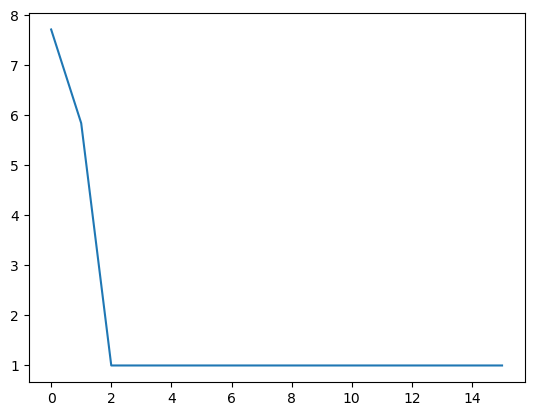

In [15]:
pde_uncertainties = []

for bs in pareto_optimal_models:
    # um = BayesianRidge(fit_intercept=False, compute_score=True, max_iter=1000)
    um = ARDRegression(fit_intercept=False, compute_score=True, max_iter=1000)
    um.fit(problem.numericalize_genome(bs[0]), y_pre.ravel())
    
    pde_uncertainty = np.sqrt(np.diag(um.sigma_)).sum()/abs(um.coef_).sum()
    pde_uncertainties.append(pde_uncertainty)

pde_uncertainties = np.array(pde_uncertainties)/min(pde_uncertainties)
print(pde_uncertainties)

plt.plot(pde_uncertainties); plt.show()

### Compromise programming

In [16]:
from collections import Counter
from pymcdm import weights as obj_w
from compromise_programming import mcdm
from bayesian_model_evidence import log_evidence

include_uncertainty = True
types = np.array([-1, -1])
assert len(pareto_optimal_models) >= 3
F = problem.evaluate(pareto_optimal_models)
# 2 criteria: acc, complexity / 3 criteria: acc, complexity, uncertainty
if include_uncertainty:
    F = np.hstack((F, pde_uncertainties.reshape(-1, 1)))
    types = np.array([-1, -1, -1])

ic = np.array([sm.OLS(y_pre, problem.numericalize_genome(bs[0])).fit().bic for bs in pareto_optimal_models])
# ic = np.array([-log_evidence(problem.numericalize_genome(bs[0]), y_pre) for bs in pareto_optimal_models])
max_ss = np.argmin(ic)+1
F = F[:max_ss]

obj_weights = obj_w.gini_weights(F, types=types)
print("Weights:", obj_weights)

# mcdm
filtered_F = F.copy()
filtered_F[:, 0:1] = ic[:max_ss].reshape(-1, 1)
while len(filtered_F) >= 3:
    ranks, prefs = mcdm(filtered_F, obj_weights, types)
    most_common = Counter(np.argmin(ranks, axis=1)).most_common()
    filtered_F = F[:most_common[0][0]+1]
    print(filtered_F, most_common)
    if len(most_common) == 1:
        break

Weights: [0.48040161 0.21570838 0.30389001]
[[0.86973165 1.         7.72032841]
 [0.64748871 2.         5.8460637 ]
 [0.03144628 3.         1.        ]] [(2, 4)]


### Intercept or NO Intercept? ###

In [17]:
# true_indices = [8, 10, 13]
# true_coefficients = [-1, -1, -1]
# true_ols = sm.OLS(y_pre, X_pre[:, true_indices]).fit()
# estimated_coefficients = true_ols.params
# print(estimated_coefficients, mean_absolute_percentage_error(true_coefficients, estimated_coefficients))
# true_ols.bic, sm.OLS(y_pre, X_pre[:, [0] + true_indices]).fit().bic